# CNN for UCI HAR

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import init
from sklearn.metrics import recall_score, f1_score, accuracy_score
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import os
import gc
import pandas as pd

In [2]:
torch.cuda.set_device(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
n_gpu = torch.cuda.device_count()
print(n_gpu)
gc.collect()

1


36

In [18]:
path = os.path.dirname(os.path.abspath("__file__"))
print(path)
pathlist = ['./UCI/x_train.npy',
            './UCI/y_train.npy',
            './UCI/x_test.npy',
            './UCI/y_test.npy']

C:\Users\cloth\Desktop\research-project\UCI HAR


In [19]:
def similarity_matrix(x, chunk_size=32):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0) with memory optimization. '''
    # Free memory before computation
    torch.cuda.empty_cache()

    # Process input tensor based on dimensions
    if x.dim() == 4:
        if x.size(1) > 3 and x.size(2) > 1:
            z = x.view(x.size(0), x.size(1), -1)
            x = z.std(dim=2)
        else:
            x = x.view(x.size(0), -1)

    # Center the data
    xc = x - x.mean(dim=1).unsqueeze(1)

    # Normalize
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc ** 2, dim=1))).unsqueeze(1)

    # Use chunking for large matrices to reduce memory usage
    batch_size = xn.size(0)

    # If batch is small enough, compute directly
    if batch_size <= chunk_size:
        R = xn.matmul(xn.transpose(1, 0)).clamp(-1, 1)
        return R

    # For larger batches, compute similarity matrix in chunks
    R = torch.zeros(batch_size, batch_size, device=xn.device)

    for i in range(0, batch_size, chunk_size):
        end_i = min(i + chunk_size, batch_size)
        chunk_i = xn[i:end_i]

        for j in range(0, batch_size, chunk_size):
            end_j = min(j + chunk_size, batch_size)
            chunk_j = xn[j:end_j]

            # Compute similarity for this chunk
            R[i:end_i, j:end_j] = chunk_i.matmul(chunk_j.transpose(1, 0)).clamp(-1, 1)

            # Free memory after each chunk computation
            torch.cuda.empty_cache()

    return R


In [20]:
def data_flat(data_y):
    data_y = np.argmax(data_y, axis=1)
    return data_y

In [21]:
def load_data(train_x_path, train_y_path, batchsize):
    # Clear GPU memory before loading data
    torch.cuda.empty_cache()


    train_x = np.load(train_x_path)
    train_x_shape = train_x.shape
    train_x = torch.from_numpy(
        np.reshape(train_x.astype(float), [train_x_shape[0], 1, train_x_shape[1], train_x_shape[2]])).cuda()

    train_y = data_flat(np.load(train_y_path))
    train_y = torch.from_numpy(train_y).cuda()

    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n',
          train_x.shape, train_y.shape,
          '\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    torch_dataset = Data.TensorDataset(train_x, train_y)
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=batchsize,
        shuffle=True,
        num_workers=0,
    )
    total = len(loader)
    # for _ in tqdm(range(total), desc='ongoing', ncols=80,postfix="train_data"):
    #     pass
    return loader

In [22]:
def quzheng_x(height, kernel_size, padding, stride, numlayer):
    list = []
    for i in range(1, numlayer + 1):
        feature = int((height - kernel_size + 2 * padding) / stride) + 1
        height = feature
        list.append(feature)
    return list

In [23]:
def quzheng_s(height, kernel_size, padding, stride, numlayer):
    list = []
    for i in range(1, numlayer + 1):
        feature = math.ceil((height - kernel_size + 2 * padding) / stride) + 1
        height = feature
        list.append(feature)
    return list

In [24]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        print('this is loss function!')

    def forward(self, output, label):
        loss_func = F.cross_entropy(output, label)
        return loss_func


In [25]:
class conv_loss_block(nn.Module):
    def __init__(self, channel_in, channel_out, stride):
        super(conv_loss_block, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.decode_ys = []
        self.bns_decode_ys = []

        decode_t_list = [29568, 21632, 15360, 35840]

        self.encoder = nn.Sequential(nn.Conv2d(self.channel_in, self.channel_out, (6, 1), stride=stride, padding=1),
                                     nn.BatchNorm2d(self.channel_out),
                                     nn.ReLU(inplace=True),
                                     )

        self.avg_pool = nn.MaxPool2d((2, 2), stride=1)

        for i in range(3):
            decode_y = nn.Linear(decode_t_list[i], 6)
            setattr(self, 'decode_y%i' % i, decode_y)
            self._set_init(decode_y)
            self.decode_ys.append(decode_y)

        self.conv_loss = nn.Conv2d(self.channel_out, self.channel_out, kernel_size=(3, 3), stride=(1, 1),
                                   padding=(1, 1), bias=False)

        if True:
            self.bn = torch.nn.BatchNorm2d(self.channel_out, momentum=0.5)
            nn.init.constant_(self.bn.weight, 1)
            nn.init.constant_(self.bn.bias, 0)

        self.nonlin = nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, amsgrad=False)

        self.clear_stats()

    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1)
        init.constant_(layer.bias, 0.2)

    def clear_stats(self):
        self.loss_sim = 0.0
        self.loss_pred = 0.0
        self.correct = 0
        self.examples = 0

    def set_learning_rate(self, lr):
        self.lr = lr

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr

    def optim_zero_grad(self):
        self.optimizer.zero_grad()

    def optim_step(self):
        self.optimizer.step()

    def forward(self, x, y, y_onehot, loop, is_training):

        h = self.encoder(x)

        h_return = h
        h_shape = h.shape

        h_return = self.dropout(h_return)

        h_loss = self.conv_loss(h_return)

        Rh = similarity_matrix(h_loss)

        # caculate unsupervised loss
        Rx = similarity_matrix(x).detach()
        loss_unsup = F.mse_loss(Rh, Rx)

        h_pool = h_return

        y_hat_local = self.decode_ys[loop](h_pool.view(h_pool.size(0), -1))
        loss_pred = (1 - 0.99) * F.cross_entropy(y_hat_local, y.detach().long())

        Ry = similarity_matrix(y_onehot).detach()
        loss_sim = 0.99 * F.mse_loss(Rh, Ry)

        loss_sup = loss_pred + loss_sim

        loss = loss_sup * 1 + loss_unsup * 0

        if is_training:
            loss.backward(retain_graph=False)

        if is_training:
            self.optimizer.step()
            self.optimizer.zero_grad()
            h_return.detach_()
        loss = loss.item()

        return h_return, loss

In [26]:
class convnet(nn.Module):
    def __init__(self, input_ch, output_ch, num_layers, num_classes):
        super(convnet, self).__init__()
        self.num_layers = num_layers
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.bn = []
        self.layers = nn.ModuleList(
            [conv_loss_block(self.input_ch, self.output_ch, stride=(3, 1))])
        self.layers.extend(
            [conv_loss_block(64, 128, stride=(3, 1)),
             conv_loss_block(128, 256, stride=(3, 1))
             ])

        self.layer_out = nn.Linear(15360, num_classes)
        self.layer_out.weight.data.zero_()

        bn = nn.BatchNorm2d(1, momentum=0.5)
        setattr(self, 'pre_bn', bn)
        self.bn.append(bn)

    def parameters(self):
        return self.layer_out.parameters()

    def set_learning_rate(self, lr):
        for i, layer in enumerate(self.layers):
            layer.set_learning_rate(lr)

    def optim_step(self):
        for i, layer in enumerate(self.layers):
            # print('下一步优化')
            layer.optim_step()

    def optim_zero_grad(self):
        for i, layer in enumerate(self.layers):
            # print('初始化optim')
            layer.optim_zero_grad()

    def forward(self, x, y, y_onehot, is_training):

        total_loss = 0.0
        for i, layer in enumerate(self.layers):

            if i == 0:
                x = x.type(torch.cuda.FloatTensor)
                # print(x.shape,'x.shape')
                x = self.bn[i](x)

            x, loss = layer(x, y, y_onehot, i, is_training)

            total_loss += loss

        x = x.contiguous().view(x.size(0), -1)
        x = self.layer_out(x)

        return x, total_loss

In [27]:
def to_one_hot(y, n_dims=None):
    ''' Take integer tensor y with n dims and convert it to 1-hot representation with n+1 dims. '''
    y_tensor = y.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

In [28]:
scaler = torch.amp.GradScaler('cuda')

def train(train_loader, val_error):

    torch.cuda.empty_cache()

    accumulation_steps = 4

    model.train()

    peak_memory = 0
    correct = 0
    total = 0

    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print('Total_Number of params: {} |Trainable_num of params: {} '.format(total_num, trainable_num))


    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.cuda(non_blocking=True)  # non_blocking=True improves performance
        batch_y = batch_y.cuda(non_blocking=True)
        with torch.no_grad():  # No need to track gradients for one-hot conversion
            target_onehot = to_one_hot(batch_y).cuda()

        optimizer.zero_grad()

        try:
            # Use mixed precision for forward and backward pass
            with torch.amp.autocast('cuda'):
                # Forward pass
                output, _ = model(batch_x, batch_y, target_onehot, True)
                loss = l(output, batch_y.long())
                # Scale loss for gradient accumulation
                loss = loss / accumulation_steps

                # Calculate training accuracy
                _, predicted = torch.max(output.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.long()).sum().item()

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Step optimizer after accumulation steps
            if (step + 1) % accumulation_steps == 0:
                # Unscale gradients for any gradient clipping (optional)
                # scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights and scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # Track peak memory usage
            current_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # Convert to MB
            peak_memory = max(peak_memory, current_memory)

            # Free memory
            del batch_x, batch_y, target_onehot, output, loss
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"OOM at training step {step}, trying to recover...")
                # Free memory
                if 'batch_x' in locals(): del batch_x
                if 'batch_y' in locals(): del batch_y
                if 'target_onehot' in locals(): del target_onehot
                if 'output' in locals(): del output
                if 'loss' in locals(): del loss
                torch.cuda.empty_cache()
                continue
            else:
                raise

    # Print peak memory usage and training accuracy
    print(f"Peak memory usage during training: {peak_memory:.2f} MB")
    train_accuracy = 100 * correct / total if total > 0 else 0
    print(f"Training accuracy: {train_accuracy:.2f}%")

In [29]:
def validate(x_val, y_val, val_error, epoch):
    model.eval()

    # Clear GPU memory before validation
    torch.cuda.empty_cache()

    # Set batch size for validation - smaller batches use less memory
    batch_size = 32

    val_dataset = Data.TensorDataset(x_val, y_val)
    val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Clear GPU memory before processing each batch
            torch.cuda.empty_cache()

            batch_x = batch_x.half().cuda()
            batch_y = batch_y.cuda()
            batch_y_onehot = to_one_hot(batch_y).cuda()

            with torch.amp.autocast('cuda'):
                batch_output, _ = model(batch_x, batch_y, batch_y_onehot, False)

            # Store predictions and targets for later evaluation
            all_predictions.append(batch_output.cpu().detach())
            all_targets.append(batch_y.cpu().detach())

            # Free memory
            del batch_x
            del batch_y
            del batch_y_onehot
            torch.cuda.empty_cache()

    all_pred_tensor = torch.cat(all_predictions, dim=0)
    all_target_tensor = torch.cat(all_targets, dim=0)

    all_pred_numpy = data_flat(all_pred_tensor.numpy())
    all_target_numpy = all_target_tensor.numpy()

    acc = accuracy_score(all_target_numpy, all_pred_numpy)
    f1 = f1_score(all_target_numpy, all_pred_numpy, average='weighted')
    reca = recall_score(all_target_numpy, all_pred_numpy, average='weighted')

    print('Epoch:', epoch, '| validation accuracy: %.8f' % acc, '| validation F1: %.8f' % f1, '| validation recall: %.8f' % reca)
    pred_classes = torch.max(all_pred_tensor, 1)[1]
    accuracy = (torch.sum(pred_classes == all_target_tensor.long()).float() / all_target_tensor.size(0))
    val_error.append((1 - accuracy.item()))

    del all_predictions, all_targets, all_pred_tensor, all_target_tensor
    torch.cuda.empty_cache()
    model.train()

In [30]:
import torch
import numpy as np
import torch.utils.data as Data

# Charger les données
x_test = np.load('./UCI/x_test.npy')
y_test = np.load('./UCI/y_test.npy')
y_test = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Convertir en tenseurs
x_test_tensor = torch.from_numpy(
    np.reshape(x_test.astype(float), [x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]])
).cuda()
y_test_tensor = torch.from_numpy(y_test).cuda()

# Calculer l'indice de séparation
split_idx = x_test_tensor.shape[0] // 2

# Première moitié : validation
x_val, y_val = x_test_tensor[:split_idx], y_test_tensor[:split_idx]
val_dataset = Data.TensorDataset(x_val, y_val)
val_loader = Data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Deuxième moitié : test
x_test2, y_test2 = x_test_tensor[split_idx:], y_test_tensor[split_idx:]
test_dataset = Data.TensorDataset(x_test2, y_test2)
test_loader = Data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [31]:
if __name__ == '__main__':

    model = convnet(1, 64, 3, 6)
    model.cuda()
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    l = nn.CrossEntropyLoss().cuda()
    train_loader = load_data(pathlist[0], pathlist[1], batchsize=400)


    # model.set_learning_rate(6e-4)
    # writer = SummaryWriter()
    train_error = []
    test_error = []
    val_error=[]
    accuracy_list = []
    lr = [0.004, 0.001, 0.0009, 0.0007, 0.0005]

    for epoch in range(500):
        torch.cuda.empty_cache()
        gc.collect()
        if epoch <= 50:
            lr_dynamic = lr[0]
            model.set_learning_rate(lr_dynamic)
        elif 51 <= epoch <= 120:
            lr_dynamic = lr[1]
            model.set_learning_rate(lr_dynamic)
        elif 121 <= epoch <= 200:
            lr_dynamic = lr[2]
            model.set_learning_rate(lr_dynamic)
        elif 201 <= epoch <= 400:
            lr_dynamic = lr[3]
            model.set_learning_rate(lr_dynamic)
        elif 401 <= epoch:
            lr_dynamic = lr[4]
            model.set_learning_rate(lr_dynamic)
        train(train_loader, [])
        validate(x_val, y_val, val_error, epoch)
    # writer.close()


convnet(
  (layers): ModuleList(
    (0): conv_loss_block(
      (encoder): Sequential(
        (0): Conv2d(1, 64, kernel_size=(6, 1), stride=(3, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (avg_pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (decode_y0): Linear(in_features=29568, out_features=6, bias=True)
      (decode_y1): Linear(in_features=21632, out_features=6, bias=True)
      (decode_y2): Linear(in_features=15360, out_features=6, bias=True)
      (conv_loss): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (nonlin): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): conv_loss_block(
      (encoder): Sequential(
        (0): Conv2d(64, 128, kernel_size=(6, 1), stride

In [32]:
from river import metrics
import psutil

In [33]:
gc.collect()
torch.cuda.empty_cache()

In [34]:
t_off, m_off = [], []
f1_cnn, mem_cnn = [], []
yt_cnn, yp_cnn = [], []
metric = metrics.Accuracy()
i = 0
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        if batch_x.dim() == 3:
            batch_x = batch_x.unsqueeze(1)
        xi2_tensor = batch_x.cuda()
        yi_tensor = batch_y.cuda()
        yi_onehot = to_one_hot(yi_tensor).cuda()
        output, _ = model(xi2_tensor, yi_tensor, yi_onehot, False)
        _, y_pred = torch.max(output.data, 1)
        y_pred_scalar = y_pred.cpu().item()
        yi = batch_y.cpu().item()
        metric.update(int(yi), y_pred_scalar)
        yt_cnn.append(yi)
        yp_cnn.append(y_pred_scalar)
        t_off.append(i)
        m_off.append(metric.get() * 100)
        f1_cnn.append(f1_score(yt_cnn, yp_cnn, average='weighted'))
        mem_cnn.append(psutil.Process().memory_info().rss / (1024 ** 2))
        i += 1

In [35]:
print("CNN accuracy :", metric.get()*100)
print("CNN F1 score final :", f1_cnn[-1]*100)
print("CNN mem final : (MB)", mem_cnn[-1])

CNN accuracy : 99.4572591587517
CNN F1 score final : 99.4565687850586
CNN mem final : (MB) 476.6171875


In [36]:
def plot_confusion(cm, class_data, title='Confusion Matrix',save_title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    classes = class_data
    im = plt.imshow(cm, interpolation='none', cmap=plt.cm.Oranges)
    plt.title(title, fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tick_params(labelsize=10)
    plt.grid(False)  # Supprime les lignes de grille

    # Affichage des valeurs réelles dans chaque case, police petite, centré
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black", fontsize=8)

    plt.tight_layout()
    plt.savefig(save_title, format='pdf')
    plt.show()

In [37]:
class_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing',
                       'Laying']

Accuracy: 99.46%
F1 score: 99.46%
Recall: 99.46%


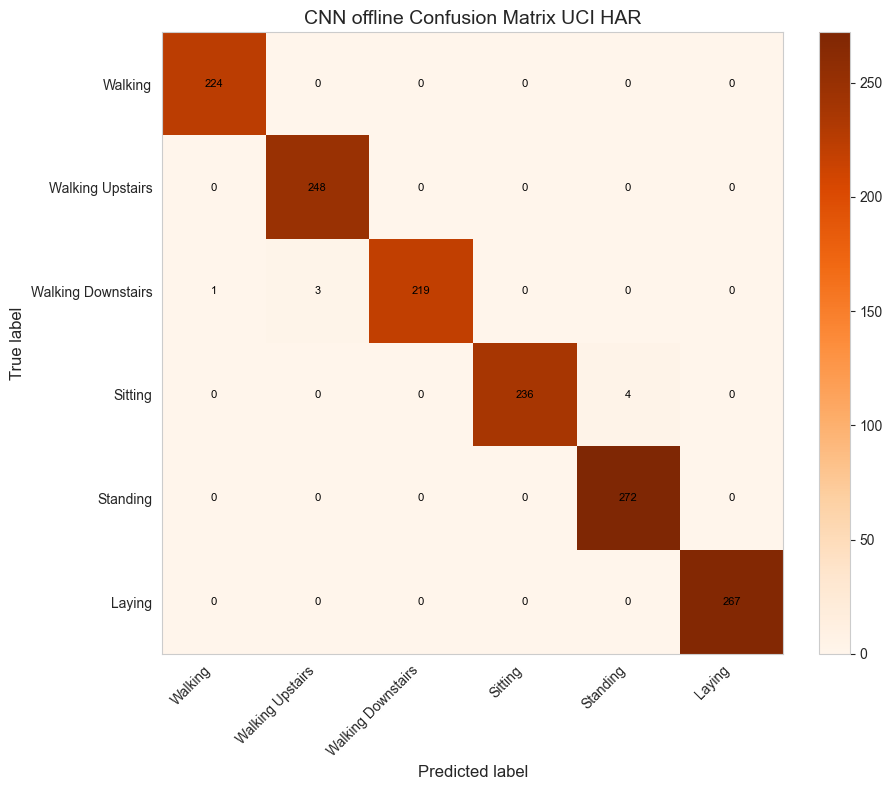

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

cm = confusion_matrix(yt_cnn, yp_cnn)
acc = accuracy_score(yt_cnn, yp_cnn)
f1 = f1_score(yt_cnn, yp_cnn, average='weighted')
recall = recall_score(yt_cnn, yp_cnn, average='weighted')

print(f'Accuracy: {acc*100:.2f}%')
print(f'F1 score: {f1*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

# Affichage de la matrice de confusion
plot_confusion(cm, class_names, title='CNN offline Confusion Matrix UCI HAR', save_title='CNN_offline_UCIHAR_ConfusionMatrix.pdf')

# Teng et al's code

In [39]:
import os
import time
import argparse
import torch
import math
import torch.nn as nn
from torch.nn import init
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import tqdm as tqdm
import torch.nn.functional as F
import  torchsnooper as torchsnooper
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,confusion_matrix
from torchvision import datasets, transforms
from torch.backends import cudnn
from bisect import bisect_right
import torch.utils.data as Data
from tqdm import tqdm

import os
torch.cuda.set_device(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
n_gpu = torch.cuda.device_count()
print(n_gpu)
path=os.path.dirname(os.path.abspath("__file__"))
print(path)
pathlist = ['./UCI/x_train.npy',
            './UCI/y_train.npy',
            './UCI/x_test.npy',
            './UCI/y_test.npy']


# this is UCIdataset. torch.Size([7352,128, 9]) torch.Size([7352]) windows size:128 channel:9 calss:6 overlap:50%



# # @torchsnooper.snoop()
def data_flat(data_y):
    data_y=np.argmax(data_y, axis=1)
    return data_y


def load_data(train_x_path, train_y_path, batchsize):
    train_x = np.load(train_x_path)
    train_x_shape = train_x.shape
    train_x = torch.from_numpy(
        np.reshape(train_x.astype(float), [train_x_shape[0],1, train_x_shape[1], train_x_shape[2]])).cuda()

    train_y = data_flat(np.load(train_y_path))
    train_y = torch.from_numpy(train_y).cuda()

    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n',
          train_x.shape, train_y.shape,
          '\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    torch_dataset = Data.TensorDataset(train_x, train_y)
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=batchsize,
        shuffle=True,
        num_workers=0,
    )
    total = len(loader)
    # for _ in tqdm(range(total), desc='ongoing', ncols=80,postfix="train_data"):
    #     pass
    return loader

def similarity_matrix(x):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0). '''
    if x.dim() == 4:
        if x.size(1) > 3 and x.size(2) > 1:
            z = x.view(x.size(0), x.size(1), -1)
            x = z.std(dim=2)
            # print('this similarity matrix x shape',x.shape)
        else:
            x = x.view(x.size(0), -1)
    xc = x - x.mean(dim=1).unsqueeze(1)
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc ** 2, dim=1))).unsqueeze(1)
    R = xn.matmul(xn.transpose(1, 0)).clamp(-1, 1)

    return R

def quzheng_x(height,kernel_size,padding,stride,numlayer):
    list=[]
    for i in range(1,numlayer+1):
        feature=int((height-kernel_size+2*padding)/stride)+1
        height=feature
        list.append(feature)
    return list

def quzheng_s(height,kernel_size,padding,stride,numlayer):
    list=[]
    for i in range(1,numlayer+1):
        feature=math.ceil((height-kernel_size+2*padding)/stride)+1
        height=feature
        list.append(feature)
    return list

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        print('this is loss function!')

    def forward(self, output, label):
        loss_func = F.cross_entropy(output, label)
        return loss_func

class conv_loss_block(nn.Module):
    def __init__(self, channel_in, channel_out,stride):
        super(conv_loss_block, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.decode_ys = []
        self.bns_decode_ys = []

        decode_t_list = [29568, 21632, 15360, 35840]

        self.encoder =nn.Sequential(nn.Conv2d(self.channel_in, self.channel_out, (6, 1),stride=stride,padding=1),
                                    nn.BatchNorm2d(self.channel_out),
                                    nn.ReLU(inplace=True),
                                    )

        self.avg_pool = nn.MaxPool2d((2, 2),stride=1)

        for i in range(3):
            decode_y = nn.Linear(decode_t_list[i], 6)
            setattr(self, 'decode_y%i' % i, decode_y)
            self._set_init(decode_y)
            self.decode_ys.append(decode_y)

        self.conv_loss = nn.Conv2d(self.channel_out, self.channel_out, kernel_size=(3, 3), stride=(1, 1),
                                   padding=(1, 1), bias=False)

        if True:
            self.bn = torch.nn.BatchNorm2d(self.channel_out, momentum=0.5)
            nn.init.constant_(self.bn.weight, 1)
            nn.init.constant_(self.bn.bias, 0)

        self.nonlin = nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, amsgrad=False)

        self.clear_stats()

    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1)
        init.constant_(layer.bias, 0.2)

    def clear_stats(self):
        self.loss_sim = 0.0
        self.loss_pred = 0.0
        self.correct = 0
        self.examples = 0

    def set_learning_rate(self, lr):
        self.lr = lr

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr

    def optim_zero_grad(self):
        self.optimizer.zero_grad()

    def optim_step(self):
        self.optimizer.step()

    def forward(self, x, y, y_onehot, loop, is_training):

        h = self.encoder(x)

        h_return = h
        h_shape = h.shape

        h_return = self.dropout(h_return)


        h_loss = self.conv_loss(h_return)

        Rh = similarity_matrix(h_loss)

        # caculate unsupervised loss
        Rx = similarity_matrix(x).detach()
        loss_unsup = F.mse_loss(Rh, Rx)

        h_pool = h_return

        y_hat_local = self.decode_ys[loop](h_pool.view(h_pool.size(0), -1))
        loss_pred = (1 - 0.99) * F.cross_entropy(y_hat_local, y.detach().long())

        Ry = similarity_matrix(y_onehot).detach()
        loss_sim = 0.99* F.mse_loss(Rh, Ry)

        loss_sup = loss_pred + loss_sim

        loss = loss_sup * 1 + loss_unsup * 0

        if is_training:
            loss.backward(retain_graph=False)

        if is_training:
            self.optimizer.step()
            self.optimizer.zero_grad()
            h_return.detach_()
        loss = loss.item()

        return h_return, loss


class convnet(nn.Module):
    def __init__(self, input_ch, output_ch, num_layers, num_classes):
        super(convnet, self).__init__()
        self.num_layers = num_layers
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.bn = []
        self.layers = nn.ModuleList(
            [conv_loss_block(self.input_ch, self.output_ch,stride=(3,1))])
        self.layers.extend(
            [conv_loss_block(64, 128,stride=(3,1)),
             conv_loss_block(128, 256,stride=(3,1))
             ])

        self.layer_out = nn.Linear(15360, num_classes)
        self.layer_out.weight.data.zero_()

        bn = nn.BatchNorm2d(1, momentum=0.5)
        setattr(self, 'pre_bn', bn)
        self.bn.append(bn)

    def parameters(self):
        return self.layer_out.parameters()

    def set_learning_rate(self, lr):
        for i, layer in enumerate(self.layers):
            layer.set_learning_rate(lr)

    def optim_step(self):
        for i, layer in enumerate(self.layers):
            # print('下一步优化')
            layer.optim_step()

    def optim_zero_grad(self):
        for i, layer in enumerate(self.layers):
            # print('初始化optim')
            layer.optim_zero_grad()

    def forward(self, x, y, y_onehot, is_training):

        total_loss = 0.0
        for i, layer in enumerate(self.layers):

            if i == 0:
                x = x.type(torch.cuda.FloatTensor)
                # print(x.shape,'x.shape')
                x = self.bn[i](x)


            x, loss = layer(x, y, y_onehot, i, is_training)

            total_loss += loss

        x = x.contiguous().view(x.size(0), -1)
        x = self.layer_out(x)

        return x, total_loss

def to_one_hot(y, n_dims=None):
    ''' Take integer tensor y with n dims and convert it to 1-hot representation with n+1 dims. '''
    y_tensor = y.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot


def train(train_loader,train_error,test_error,accuracy_list,epoch):
    model_teng.train()

    total_num = sum(p.numel() for p in model_teng.parameters())
    trainable_num = sum(p.numel() for p in model_teng.parameters() if p.requires_grad)


    print('Total_Number of params: {} |Trainable_num of params: {} '.format(total_num, trainable_num))
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        target_onehot = to_one_hot(batch_y)
        target_onehot = target_onehot.cuda()

        optimizer.zero_grad()
        output,loss= model_teng(batch_x,batch_y, target_onehot,True)

        # print(output.shape,batch_y.shape,target_onehot.shape,'output.shape')

        loss = loss_func (output, batch_y.long())

        loss.backward()
        optimizer.step()
        if epoch % 1 == 0:
            model_teng.eval()

            test_x = x_test2
            test_x_shape = test_x.shape
            test_x = test_x.cpu().numpy()
            print("Shape avant reshape :", test_x.shape)
            test_x = torch.from_numpy(test_x).float().cuda()

            test_y = y_test2

            test_y_onehot = to_one_hot(test_y)
            test_y_onehot = test_y_onehot.cuda()

            # print(test_x.shape, test_y.shape, test_y_onehot.shape, 'test_x.shape,test_y.shape,target_y.shape')
            try:
                test_output,_ = model_teng(test_x,test_y, test_y_onehot,False)
                test_output_copy = test_output
                # print(test_output.shape)
                test_output = data_flat(test_output.cpu().detach().numpy())
                # print(test_output.shape, 'test_output')

                test_output_f1 = np.asarray(pd.get_dummies(test_output))

                print(test_y_onehot.shape, test_output_f1.shape)
                acc = accuracy_score(test_y_onehot.cpu().numpy(), test_output_f1)
                f1 = f1_score(test_y_onehot.cpu().numpy(), test_output_f1, average='weighted')
                f2 = f1_score(test_y_onehot.cpu().numpy(), test_output_f1, average='micro')
                f3 = f1_score(test_y_onehot.cpu().numpy(), test_output_f1, average='macro')
                reca = recall_score(test_y_onehot.cpu().numpy(), test_output_f1, average='weighted')
                # print(confusion_y.tolist(), '\n', test_output_f1_con.tolist())
                print('Epoch: ', epoch, '| test accuracy: %.8f' % acc, '| test F1: %.8f' % f1, '| test recall: %.8f' % reca,
                      '| test micro: %.8f' % f2, '| test micro: %.8f' % f3)
                #
                test_output = torch.max(test_output_copy, 1)[1].cuda()
                # print(test_output.shape,'test_output.shape')
                accuracy = (torch.sum(test_output == test_y.long()).type(torch.FloatTensor) / test_y.size(0)).cuda()
                # print('Epoch: ', epoch, '| test accuracy: %.8f' % accuracy)
                test_error.append((1 - accuracy.item()))
                model_teng.train()
            except ValueError:
                print('error')
            else:
                pass
                pass

    # np.save('./matplotlib_picture/UCI_error/bp_test.npy',test_error)

import psutil
import gc
def test(model_teng, t, m):

    torch.cuda.empty_cache()
    gc.collect()
    model_teng.eval()
    test_x = x_test2
    test_x_shape = test_x.shape
    test_x = test_x.float().cuda()

    test_y = y_test2
    test_y_onehot = to_one_hot(test_y)
    test_y_onehot = test_y_onehot.cuda()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for i in range(test_x.shape[0]):
            xi = test_x[i].unsqueeze(0)
            yi = test_y[i].unsqueeze(0)
            yi_onehot = test_y_onehot[i].unsqueeze(0)
            output, _ = model_teng(xi, yi, yi_onehot, False)
            pred = torch.argmax(output, dim=1).item()
            y_true.append(yi.item())
            y_pred.append(pred)
            t.append(i)
            acc = accuracy_score(y_true, y_pred)
            m.append(acc * 100)

    # Matrice de confusion et affichage
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    plot_confusion(cm, class_names, title='Teng et al.\'s CNN Confusion Matrix on UCI HAR', save_title='CNN_teng_ConfusionMatrix_UCIHAR.pdf')
    print("Accuracy:", sum(m) / len(m))
    mem_used = psutil.Process().memory_info().rss / (1024 ** 2)
    print(f"Memoire utilisee pendant le test : {mem_used:.2f} MB")
    return t,m

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

def plot_confusion(cm, class_data, title='Confusion Matrix', save_title='Confusion_Matrix.pdf'):
    plt.figure(figsize=(10, 8))
    classes = class_data
    im = plt.imshow(cm, interpolation='none', cmap=plt.cm.Oranges)
    plt.title(title, fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tick_params(labelsize=10)
    plt.grid(False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black", fontsize=8)
    plt.tight_layout()
    plt.savefig(save_title, format='pdf')
    plt.show()
t_bl,m_bl=[],[]
if __name__ == '__main__':

        model_teng = convnet(1, 64, 3, 6)
        model_teng.cuda()
        print(model_teng)

        optimizer = torch.optim.Adam(model_teng.parameters(), lr=5e-4)
        loss_func = nn.CrossEntropyLoss().cuda()
        train_loader = load_data(pathlist[0], pathlist[1], batchsize=4000)
        # model_teng.set_learning_rate(6e-4)
        # writer = SummaryWriter()
        train_error=[]
        test_error=[]
        accuracy_list=[]
        lr=[0.004,0.001,0.0009,0.0007,0.0005]

        for epoch in range(500):
            if epoch<=50:
                lr_dynamic=lr[0]
                model_teng.set_learning_rate(lr_dynamic)
            elif 51<=epoch<=120:
                lr_dynamic=lr[1]
                model_teng.set_learning_rate(lr_dynamic)
            elif 121<=epoch<=200:
                lr_dynamic=lr[2]
                model_teng.set_learning_rate(lr_dynamic)
            elif 201<=epoch<=400:
                lr_dynamic=lr[3]
                model_teng.set_learning_rate(lr_dynamic)
            elif 401<=epoch:
                lr_dynamic=lr[4]
                model_teng.set_learning_rate(lr_dynamic)
            train(train_loader,train_error,test_error,accuracy_list,epoch)


1
C:\Users\cloth\Desktop\research-project\UCI HAR
convnet(
  (layers): ModuleList(
    (0): conv_loss_block(
      (encoder): Sequential(
        (0): Conv2d(1, 64, kernel_size=(6, 1), stride=(3, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (avg_pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (decode_y0): Linear(in_features=29568, out_features=6, bias=True)
      (decode_y1): Linear(in_features=21632, out_features=6, bias=True)
      (decode_y2): Linear(in_features=15360, out_features=6, bias=True)
      (conv_loss): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (nonlin): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): conv_loss_block(
      (encoder): Sequential(
     

In [40]:
def test(model_teng, t, m):

    torch.cuda.empty_cache()
    gc.collect()
    model_teng.eval()
    test_x = x_test2
    test_x_shape = test_x.shape
    test_x = test_x.float().cuda()

    test_y = y_test2
    test_y_onehot = to_one_hot(test_y)
    test_y_onehot = test_y_onehot.cuda()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for i in range(test_x.shape[0]):
            xi = test_x[i].unsqueeze(0)
            yi = test_y[i].unsqueeze(0)
            yi_onehot = test_y_onehot[i].unsqueeze(0)
            output, _ = model_teng(xi, yi, yi_onehot, False)
            pred = torch.argmax(output, dim=1).item()
            y_true.append(yi.item())
            y_pred.append(pred)
            t.append(i)
            acc = accuracy_score(y_true, y_pred)
            m.append(acc * 100)

    # Matrice de confusion et affichage
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    plot_confusion(cm, class_names, title='Teng et al.\'s CNN Confusion Matrix on UCI HAR', save_title='CNN_teng_ConfusionMatrix_UCIHAR.pdf')
    print("Accuracy:", sum(m) / len(m))
    mem_used = psutil.Process().memory_info().rss / (1024 ** 2)
    print(f"Memoire utilisee pendant le test : {mem_used:.2f} MB")
    return t,m

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

In [41]:
def plot_confusion(cm, class_data, title='Confusion Matrix', save_title='Confusion_Matrix.pdf'):
    plt.figure(figsize=(10, 8))
    classes = class_data
    im = plt.imshow(cm, interpolation='none', cmap=plt.cm.Oranges)
    plt.title(title, fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tick_params(labelsize=10)
    plt.grid(False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black", fontsize=8)
    plt.tight_layout()
    plt.savefig(save_title, format='pdf')
    plt.show()

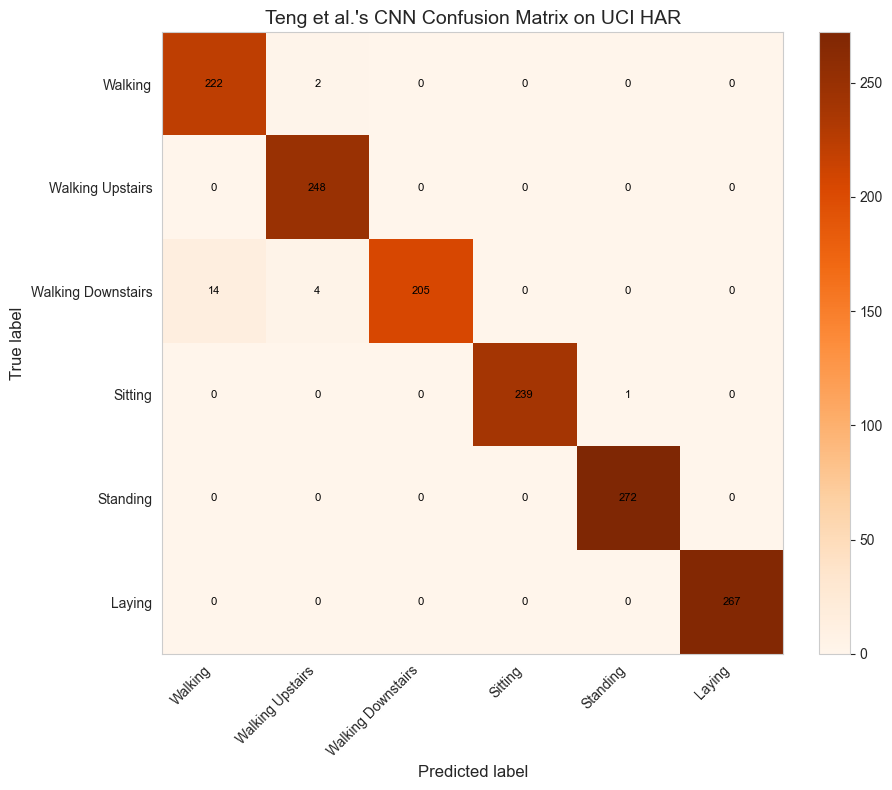

Accuracy: 97.8711278079697
Memoire utilisee pendant le test : 544.62 MB


In [43]:
t_bl,m_bl=test(model_teng,t_bl,m_bl)

In [44]:
import seaborn as sns

In [45]:
# Define OASW with a figure
def plot(t_off, m_off,t_bl=None, m_bl=None):
    plt.rcParams.update({'font.size': 28})
    plt.figure(figsize=(18, 10))
    sns.set_style("whitegrid")
    plt.clf()

    if t_off is not None and m_off is not None:
        plt.plot(t_off, m_off, color='red', label='Offline CNN, Accuracy: %.2f%%' % m_off[-1])
    if t_bl is not None and m_bl is not None:
        plt.plot(t_bl, m_bl, color='green', label='Teng et al.\'s CNN, Accuracy: %.2f%%' % m_bl[-1])

    # Points de drift

    plt.legend(loc='lower right')
    plt.ylim(95, 101)
    plt.xlim(0,1500)
    plt.xlabel('Sample index', fontsize=25)
    plt.ylabel('Accuracy (%)',fontsize=25)
    plt.tight_layout()
    plt.title("Performance comparison on UCI HAR")
    plt.savefig('cnn_UCIHAR.pdf', format='pdf')
    plt.show()

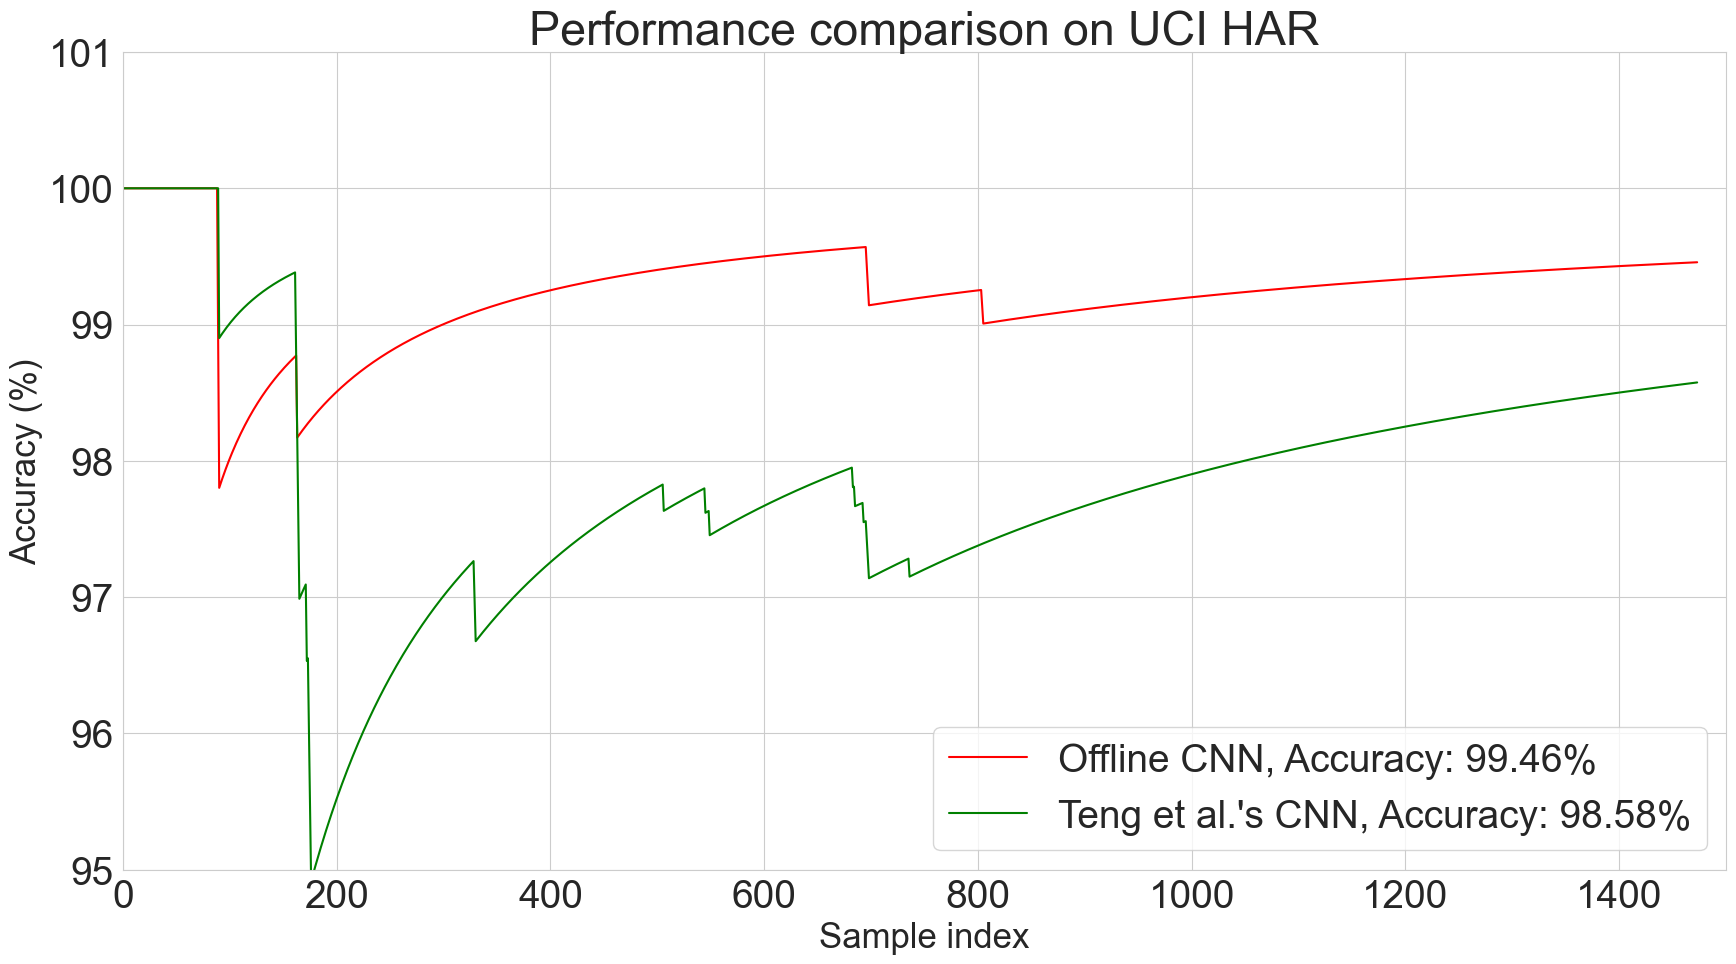

In [46]:
plot(t_off, m_off, t_bl, m_bl)

# OASW

In [47]:
# Define the OASW method using CNN instead of LightGBM
def oasw(model, optimizer, loss_fn, test_loader, a=0.99, b=0.95, win1=200, win2=1000):
    model.eval()
    metric = metrics.Accuracy()

    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i = 0
    yt = []
    yp = []
    x_new = []
    y_new = []
    dr = []
    d = 0
    f = 0
    tt = 0
    th = 0
    xt = []
    t = []
    m = []
    f1s = []
    mems = []

    for batch_x, batch_y in test_loader:
        xi2_tensor = batch_x.cuda()
        yi_tensor = batch_y.cuda()
        yi_onehot = to_one_hot(yi_tensor).cuda()

        # Prédiction
        with torch.no_grad():
            output, _ = model(xi2_tensor, yi_tensor, yi_onehot, False)
            _, y_pred = torch.max(output.data, 1)
            y_pred_scalar = y_pred.item()

        yi = batch_y.item()
        xi2 = batch_x.cpu().numpy()

        # Update the metric
        metric.update(int(yi), y_pred_scalar)

        # Store the y_test, y_pred, and x_test
        yt.append(int(yi))
        yp.append(y_pred_scalar)
        xt.append(xi2[0])

        t.append(i)
        acc_current = metric.get() * 100
        m.append(acc_current)

        # F1 score cumulatif
        f1s.append(f1_score(yt, yp, average='weighted'))
        # Mémoire GPU utilisée (en MB)
        mems.append(torch.cuda.max_memory_allocated() / (1024 ** 2))

        # Monitor the accuracy changes in the sliding window
        if i > 2 * win1:
            acc1 = accuracy_score(yt[i - win1:], yp[i - win1:])  # Current window accuracy
            acc2 = accuracy_score(yt[i - 2 * win1:i - win1], yp[i - 2 * win1:i - win1])  # Last window accuracy
            if (d == 0) & (acc1 < a * acc2):  # If the window accuracy drops to the warning level
                x_new.append(xi2[0])
                y_new.append(int(yi))
                d = 1
                print("Warning level")
            if d == 1:  # In the warning level
                tt = len(y_new)
                if acc1 < b * acc2:  # If the window accuracy drops to the drift level
                    dr.append(i)  # Record the drift start point
                    f = i
                    if tt < win1:  # if enough new concept samples are collected
                        # Retrain with recent samples
                        model.train()
                        # Convert xt and yt to tensors for training
                        recent_x = np.array(xt[i - win1:])
                        recent_y = np.array(yt[i - win1:])
                        recent_x_tensor = torch.from_numpy(recent_x).float().cuda()
                        recent_y_tensor = torch.from_numpy(recent_y).long().cuda()
                        recent_y_onehot = to_one_hot(recent_y_tensor).cuda()

                        print("debut train warning1")
                        # Train for a few iterations
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(recent_x_tensor, recent_y_tensor, recent_y_onehot, True)
                            loss = loss_fn(output, recent_y_tensor)
                            loss.backward()
                            optimizer.step()
                        print("fin train warning1")
                    else:
                        # Retrain with new concept samples
                        model.train()
                        # Convert x_new and y_new to tensors for training
                        new_x = np.array(x_new)
                        new_y = np.array(y_new)
                        new_x_tensor = torch.from_numpy(new_x).float().cuda()
                        new_y_tensor = torch.from_numpy(new_y).long().cuda()
                        new_y_onehot = to_one_hot(new_y_tensor).cuda()

                        # Train for a few iterations
                        print("debut train warning2")
                        model.train()
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                            loss = loss_fn(output, new_y_tensor)
                            loss.backward()
                            optimizer.step()
                        model.eval()
                        print("fin train warning2")
                    d = 2
                    print("Drift level")
                elif (acc1 > a * acc2) | (tt == win2):  # If the window accuracy increases back to normal
                    x_new = []
                    y_new = []
                    d = 0
                else:
                    x_new.append(xi2[0])
                    y_new.append(int(yi))
            if d == 2:  # In the drift level
                tt = len(y_new)
                acc3 = accuracy_score(yt[f:f + win1], yp[f:f + win1])
                x_new.append(xi2[0])
                y_new.append(int(yi))
                if tt >= win1:
                    if acc1 < a * acc3:  # When new concept accuracy drops to the warning level
                        if th == 0:
                            # Retrain with new concept samples
                            model.train()
                            # Convert x_new and y_new to tensors for training
                            new_x = np.array(x_new)
                            new_y = np.array(y_new)
                            new_x_tensor = torch.from_numpy(new_x).float().cuda()
                            new_y_tensor = torch.from_numpy(new_y).long().cuda()
                            new_y_onehot = to_one_hot(new_y_tensor).cuda()

                            print("debut train train1")
                            # Train for a few iterations
                            model.train()
                            for _ in range(10):
                                optimizer.zero_grad()
                                output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                                loss = loss_fn(output, new_y_tensor)
                                loss.backward()
                                optimizer.step()
                            model.eval()
                            print("fin train train1")
                            th = 1
                    if (th == 1) & (tt == win2):  # When sufficient new concept samples are collected
                        # Retrain with new concept samples
                        model.train()
                        # Convert x_new and y_new to tensors for training
                        new_x = np.array(x_new)
                        new_y = np.array(y_new)
                        new_x_tensor = torch.from_numpy(new_x).float().cuda()
                        new_y_tensor = torch.from_numpy(new_y).long().cuda()
                        new_y_onehot = to_one_hot(new_y_tensor).cuda()

                        print("debut train train2")
                        # Train for a few iterations
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                            loss = loss_fn(output, new_y_tensor)
                            loss.backward()
                            optimizer.step()

                        print("fin train train2")
                        x_new = []
                        y_new = []
                        d = 0  # Go back to the normal state
                        th = 0
                        print("retour etat normal")

        i = i + 1
    score = metric.get()
    print(f"{a} {b} {win1} {win2} {score}")  # Output accuracy
    print("accuracy: ", m[-1])
    print("F1 score: ", f1s[-1])
    print("Mémoire max utilisée (MB):", max(mems))
    return score, t, m, dr


In [48]:
import copy
import torch.nn as nn

In [49]:

a_opti = 0.986
b_opti = 0.959
w1_opti = 6000
w2_opti = 1500

In [50]:
gc.collect()
torch.cuda.empty_cache()

In [51]:
print("Running OASW with CNN...")
model_copy = copy.deepcopy(model)
opti_copy = torch.optim.Adam(model_copy.parameters(), lr=5e-4, weight_decay=1e-5)
score, t_oasw, m_oasw, dr = oasw(model_copy, opti_copy, l, test_loader, a=a_opti, b=b_opti, win1=w1_opti, win2=w2_opti)
#weight_decay à 1e-5 avant
print("OASW with CNN completed.")

Running OASW with CNN...
0.986 0.959 6000 1500 0.994572591587517
accuracy:  99.4572591587517
F1 score:  0.994565687850586
Mémoire max utilisée (MB): 4644.43994140625
OASW with CNN completed.


In [52]:
# Define OASW with a figure
def oasw_plot(t_oasw, m_oasw, dr, t_off, m_off,t_bl, m_bl):
    plt.rcParams.update({'font.size': 28})
    plt.figure(figsize=(18, 10))
    sns.set_style("whitegrid")
    plt.clf()

    # Courbe OASW+CNN


    if t_off is not None and m_off is not None:
        plt.plot(t_off, m_off, color='red', linewidth=2,label='Offline CNN, Accuracy: %.2f%%' % m_off[-1])
    if t_bl is not None and m_bl is not None:
        plt.plot(t_bl, m_bl, color='green', linewidth=2,label='Teng et al.\'s CNN, Accuracy: %.2f%%' % m_bl[-1])

    # Points de drift
    for i in dr:
        plt.axvline(x=i, color='purple', linestyle='--', linewidth=4, label='Drift' if i == dr[0] else "")
    for i in range(len(dr)):
        plt.scatter(dr[i],m_oasw[dr[i]], linewidth=4,s=200,c='r')


    plt.plot(t_oasw, m_oasw, 'blue', label='OASW+CNN, Accuracy: %.2f%%' % m_oasw[-1],linestyle='dotted', linewidth=4)

    plt.legend(loc='lower right')
    plt.ylim(94, 101)
    plt.xlim(0,1500)
    plt.xlabel('Sample index', fontsize=25)
    plt.ylabel('Accuracy (%)',fontsize=25)
    plt.title("Performance comparison on UCI HAR")
    plt.tight_layout()
    plt.savefig('cnn.pdf', format='pdf')
    plt.show()

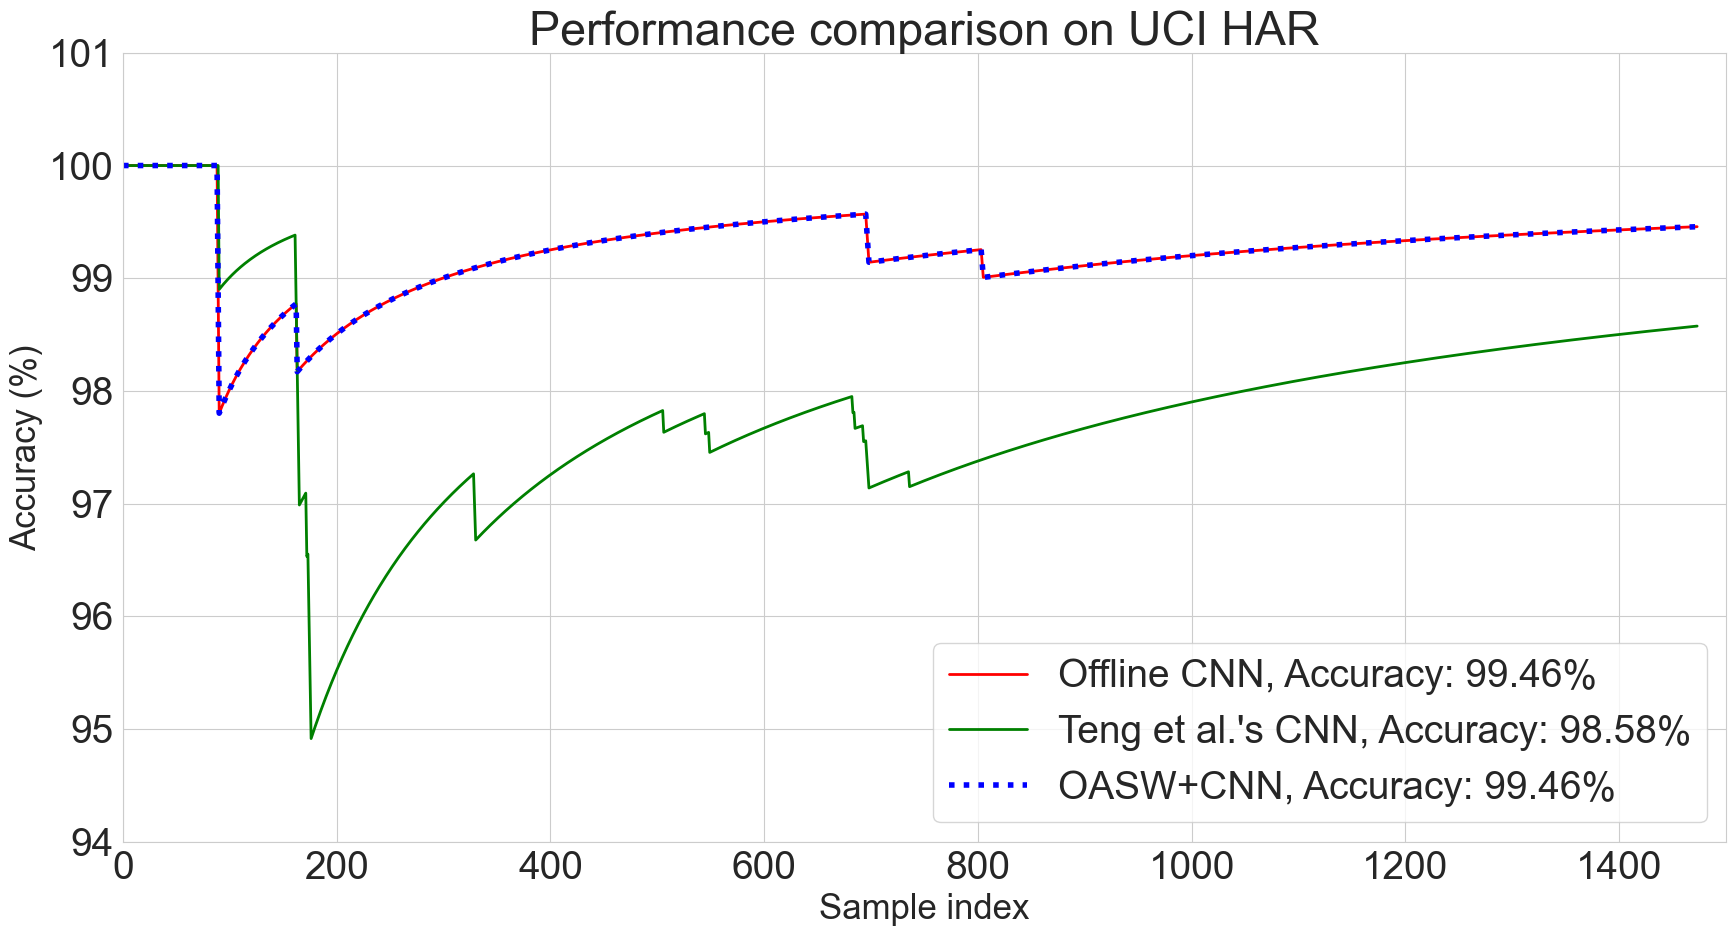

In [53]:
oasw_plot(t_oasw, m_oasw, dr, t_off, m_off, t_bl, m_bl)